In [1]:
import torch
torch.cuda.empty_cache()

In [281]:
import numpy as np
import pandas as pd
import os 
import cv2 as cv
import matplotlib.pyplot as plt
#增強紅色血管或血塊
local=r"C:\Users\st030\drd\retina-train\2"
def intensecolor(pic):
    img=cv.imread(pic)
    hsvi= cv.cvtColor(img, cv.COLOR_BGR2HSV)
    mask1=cv.inRange(hsvi,(0, 25, 70),(11, 255, 255))
    mask2=cv.inRange(hsvi,(170, 20, 70),(180, 255, 255))
    maskr=cv.bitwise_or(mask1,mask2)
    lutr=np.array([min(int(1.6*i),255) for i in range(256)]).astype('uint8')
    h,s,v=cv.split(hsvi)
    bsr=cv.LUT(s,lutr)
    s=np.where(maskr>0,bsr,s)
    hsvic=cv.merge([h,s,v])
    output= cv.cvtColor(hsvic,cv.COLOR_HSV2BGR)
    cv.imwrite(pic,output)
    
for image in os.listdir(local):
    imgd= os.path.join(local,image)
    intensecolor(imgd)
    print(image, "is over")

10017_right_2.jpeg is over
10785_left_2.jpeg is over
10954_left_2.jpeg is over
1099_right_2.jpeg is over
11730_right_2.jpeg is over
11896_right_2.jpeg is over
12014_right_2.jpeg is over
1350_left_2.jpeg is over
13651_right_2.jpeg is over
13664_left_2.jpeg is over
13664_right_2.jpeg is over
13669_left_2.jpeg is over
13705_left_2.jpeg is over
13811_right_2.jpeg is over
13819_right_2.jpeg is over
13938_left_2.jpeg is over
13966_left_2.jpeg is over
14084_left_2.jpeg is over
1430_left_2.jpeg is over
1430_right_2.jpeg is over
14436_right_2.jpeg is over
14765_right_2.jpeg is over
14844_right_2.jpeg is over
15149_left_2.jpeg is over
15343_left_2.jpeg is over
15388_left_2.jpeg is over
15414_left_2.jpeg is over
15414_right_2.jpeg is over
16007_right_2.jpeg is over
16114_left_2.jpeg is over
16114_right_2.jpeg is over
16309_right_2.jpeg is over
16392_right_2.jpeg is over
16413_right_2.jpeg is over
16565_right_2.jpeg is over
16802_right_2.jpeg is over
16_right_2.jpeg is over
17221_left_2.jpeg is ov

In [295]:
import numpy as np
import pandas as pd
import os 
import cv2 as cv
import matplotlib.pyplot as plt

local=r"C:\Users\st030\drd\retina-val\2"
for image in os.listdir(local):
    imgd= os.path.join(local,image)
    img=cv.imread(imgd)
    img=cv.bilateralFilter(img,d= 2,sigmaColor=40,sigmaSpace=40)
    limg=cv.cvtColor(img,cv.COLOR_BGR2LAB)
    l,a,b=cv.split(limg)
    clahe=cv.createCLAHE(clipLimit=2,tileGridSize=(8,8))
    lr=clahe.apply(l)
    limgr=cv.merge([lr,a,b])
    imgr=cv.cvtColor(limgr,cv.COLOR_LAB2BGR)
    cv.imwrite(imgd,imgr)
    print(image, "is over")
#增強對比度

12108_left_2.jpeg is over
12419_right_2.jpeg is over
12861_left_2.jpeg is over
13038_right_2.jpeg is over
13387_left_2.jpeg is over
13588_right_2.jpeg is over
21096_right_2.jpeg is over
21190_left_2.jpeg is over
21190_right_2.jpeg is over
21373_left_2.jpeg is over
21373_right_2.jpeg is over
21444_left_2.jpeg is over
21511_right_2.jpeg is over
21788_left_2.jpeg is over
22160_right_2.jpeg is over
22379_left_2.jpeg is over
22379_right_2.jpeg is over
22568_right_2.jpeg is over
22665_left_2.jpeg is over
22669_left_2.jpeg is over
22801_right_2.jpeg is over
22901_left_2.jpeg is over
22901_right_2.jpeg is over
23326_left_2.jpeg is over
23422_right_2.jpeg is over
23433_left_2.jpeg is over
23648_right_2.jpeg is over
23692_right_2.jpeg is over
24010_right_2.jpeg is over
24019_left_2.jpeg is over
24019_right_2.jpeg is over
24472_left_2.jpeg is over
24772_left_2.jpeg is over
24910_right_2.jpeg is over
25080_left_2.jpeg is over
25080_right_2.jpeg is over
25181_left_2.jpeg is over
25378_right_2.jpeg 

In [7]:
import numpy as np
import pandas as pd
import os 
import cv2 as cv
from sklearn.utils.class_weight import compute_class_weight
#得到不平衡資料集的加權
local=r"C:\Users\st030\drd\retina-train"

labelk=['0','1','2']
y={idk:[] for idk in range(len(labelk))}
y1=[]
for file in os.listdir(local):
    imgd= os.path.join(local,file)
    if os.path.isdir(imgd) and file in labelk:
        lid=int(file)
    for files in os.listdir(imgd):
        cimgd=os.path.join(imgd,files)
        y[lid].append(cimgd)
for label,paths in y.items():
    y1.extend([label]*len(paths))

cw= compute_class_weight(class_weight='balanced',classes=np.array([0,1,2]),y=np.array(y1))

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as f
#設定focalloss
class focalloss(nn.Module):
    def __init__(self,class_num=3,alpha=None,gamma=2,size_average=True):
        super(focalloss,self).__init__()
        self.gamma=gamma
        self.class_num=class_num
        self.size_average=size_average
        if alpha is None:
            self.alpha=torch.ones(class_num)
        else:
            self.alpha=torch.tensor(alpha,dtype=torch.float32)
    def forward(self,inputs,targets):
        N=inputs.size(0)
        C=inputs.size(1)
        if inputs.is_cuda :
            self.alpha=self.alpha.to(inputs.device)
        log_p=F.log_softmax(inputs,dim=1)
        class_mask=torch.zeros(N,C,device=inputs.device)
        targets=targets.long().clamp(0,self.class_num-1)#這邊是[32,3]
        targets=targets.argmax(dim=1)#我們要[32,1]，所以只挑出column中最大的值之索引
        ids= targets.view(-1,1)
        class_mask.scatter_(1,ids,1.0)
        alpha=self.alpha[ids.squeeze()]
        probs=(log_p.exp()*class_mask).sum(1)
        focal_loss=-alpha*torch.pow(1-probs,self.gamma)*log_p.gather(1,ids).squeeze()
        return focal_loss.mean() if self.size_average else focal_loss.sum()

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import models
from torchvision import transforms
from PIL import Image
from sklearn.metrics import accuracy_score
from torchvision import datasets
train_data=r"C:\Users\st030\drd\retina-train"
#計算圖片載入時用的mean和std
def getStat(train_data):
    tf=transforms.ToTensor()
    ds=datasets.ImageFolder(root=train_data,transform=tf)
    train_loader=torch.utils.data.DataLoader(ds,batch_size=64,num_workers=0,pin_memory=True)
    mean=torch.zeros(3)
    std=torch.zeros(3)
    for X,_ in train_loader:
        for d in range(3):
            mean[d] += X[:,d,:,:].mean()
            std[d] += X[:,d,:,:].std()
    mean.div_(len(train_data))
    std.div_(len(train_data))
    return list(mean.numpy()),list(std.numpy())
a,b=getStat(train_data)
print(a,b)

[0.3741023, 0.24712038, 0.17004183] [0.3302501, 0.22753409, 0.1769371]


In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import models
from torchvision import transforms
from PIL import Image
from sklearn.metrics import accuracy_score
from torchvision import datasets
#載入數據
traindata=r"C:\Users\st030\drd\retina-train"
def load_data(data_dir,batch_size=64,transform=None):
    if transform is None:
        transform=transforms.Compose([transforms.RandomHorizontalFlip(),transforms.RandomRotation(20),transforms.RandomAffine(degrees=0,translate=(0.1,0.1)),transforms.ToTensor(),transforms.Normalize(mean=[0.3741023, 0.24712038, 0.17004183],std=[0.3302501, 0.22753409, 0.1769371])])
    dataset=datasets.ImageFolder(root=data_dir,transform=transform)
    dl=DataLoader(dataset,batch_size=batch_size,shuffle=True)
    return dl
td=load_data(traindata)

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import models
from torchvision import transforms
from PIL import Image
from sklearn.metrics import accuracy_score
from torchvision import datasets
class mixupcutmix:
    def __init__(self,alpha=1.0,mixup_prob=0.3,cutmix_prob=0.3):
        self.alpha=alpha
        self.mixup_prob=mixup_prob
        self.cutmix_prob=cutmix_prob
    def rand_bbox(self,size,lam):
        w=size[2]
        h=size[3]
        cut_w=int(w*np.sqrt(1-lam))
        cut_h=int(h*np.sqrt(1-lam))
        cx=np.random.randint(w)
        cy=np.random.randint(h)
        bbx1=np.clip(cx-cut_w //2,0,w) # 剪裁區域的左上角 x 座標
        bby1=np.clip(cy-cut_h //2,0,h)# 剪裁區域的左上角 y 座標
        bbx2=np.clip(cx+cut_w //2,0,w)# 剪裁區域的右下角 x 座標
        bby2=np.clip(cy+cut_h //2,0,h)# 剪裁區域的右下角 y 座標
        return bbx1,bby1,bbx2,bby2    
    def mixup_cutmix(self,x,y):
        prob=np.random.rand()
        batch_size=x.size(0)
        index=torch.randperm(batch_size).to(x.device)
        lam=np.random.beta(self.alpha,self.alpha) if self.alpha >0 else 1
        if prob < self.mixup_prob:
            x=lam*x+(1-lam)*x[index,:]
            y_a,y_b=y,y[index]
        elif prob < self.mixup_prob+self.cutmix_prob:
            bbx1,bby1,bbx2,bby2=self.rand_bbox(x.size(),lam)
            x[:,:,bbx1:bbx2,bby1:bby2]=x[index,:,bbx1:bbx2,bby1:bby2]
            lam = 1-((bbx2-bbx1)*(bby2-bby1)/(x.size(2)*x.size(3)))
            y_a,y_b=y,y[index]
        else:
            x=x
            y_a,y_b=y.clone(),y.clone()
            lam=1
        
        return x,y_a,y_b,lam
    def mixup_cutmix_criterion(self,criterion,pred,y_a,y_b,lam):
        
        return lam*criterion(pred,y_a)+(1-lam)*criterion(pred, y_b) if y_b is not None else criterion(pred,y_a)





#增強學習能力的函數

------Fold15-----
Epoch 1,train loss:0.4657, val loss:0.4741,train acc:0.4017, val acc:0.5048
Epoch 2,train loss:0.4397, val loss:0.4300,train acc:0.5348, val acc:0.5287
Epoch 3,train loss:0.3784, val loss:0.3944,train acc:0.5845, val acc:0.5000
Epoch 4,train loss:0.3415, val loss:0.3967,train acc:0.5713, val acc:0.5311
Epoch 5,train loss:0.3288, val loss:0.3779,train acc:0.6109, val acc:0.5478
Epoch 6,train loss:0.2874, val loss:0.3916,train acc:0.6187, val acc:0.5622
Epoch 7,train loss:0.2693, val loss:0.3695,train acc:0.6457, val acc:0.5502
Epoch 8,train loss:0.2529, val loss:0.3973,train acc:0.6721, val acc:0.5789
Epoch 9,train loss:0.2411, val loss:0.4044,train acc:0.6439, val acc:0.5670
Epoch 10,train loss:0.2353, val loss:0.3898,train acc:0.6805, val acc:0.5694
Epoch 11,train loss:0.2393, val loss:0.4365,train acc:0.6942, val acc:0.6029
Epoch 12,train loss:0.2097, val loss:0.4318,train acc:0.7044, val acc:0.6029
Epoch 13,train loss:0.1928, val loss:0.4065,train acc:0.6924, val a

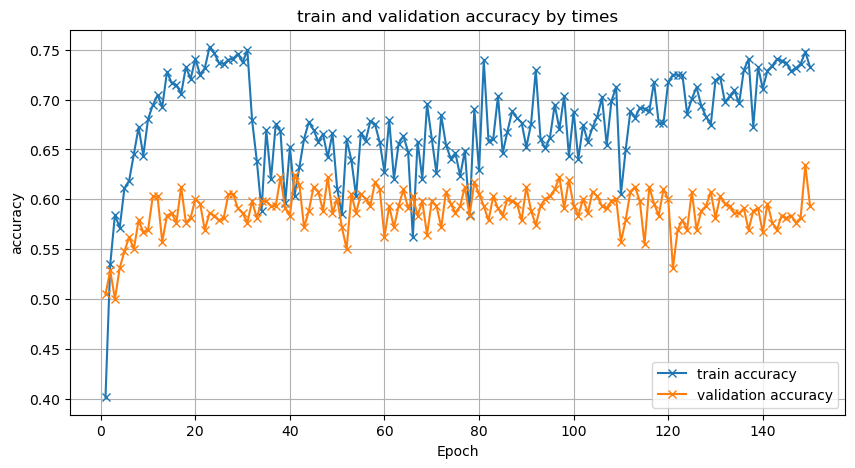

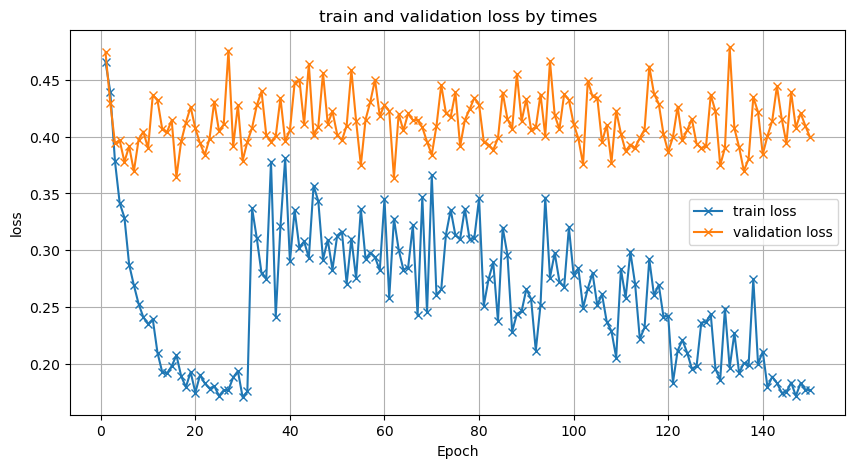

------Fold25-----
Epoch 1,train loss:0.4765, val loss:0.4728,train acc:0.3793, val acc:0.5084
Epoch 2,train loss:0.4256, val loss:0.4161,train acc:0.4907, val acc:0.5635
Epoch 3,train loss:0.3839, val loss:0.3780,train acc:0.5656, val acc:0.6019
Epoch 4,train loss:0.3479, val loss:0.3460,train acc:0.5848, val acc:0.6163
Epoch 5,train loss:0.3060, val loss:0.3575,train acc:0.6129, val acc:0.5923
Epoch 6,train loss:0.2843, val loss:0.3417,train acc:0.6501, val acc:0.6163
Epoch 7,train loss:0.2626, val loss:0.3753,train acc:0.6633, val acc:0.5827
Epoch 8,train loss:0.2432, val loss:0.3535,train acc:0.6878, val acc:0.6187
Epoch 9,train loss:0.2322, val loss:0.3584,train acc:0.6765, val acc:0.6187
Epoch 10,train loss:0.2098, val loss:0.3709,train acc:0.7022, val acc:0.6283
Epoch 11,train loss:0.2064, val loss:0.3921,train acc:0.7082, val acc:0.6187
Epoch 12,train loss:0.1965, val loss:0.3785,train acc:0.7268, val acc:0.6235
Epoch 13,train loss:0.1954, val loss:0.4168,train acc:0.7358, val a

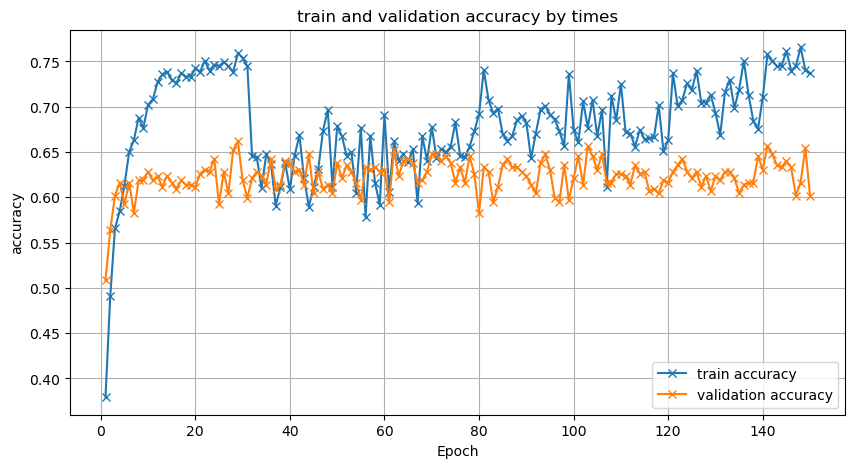

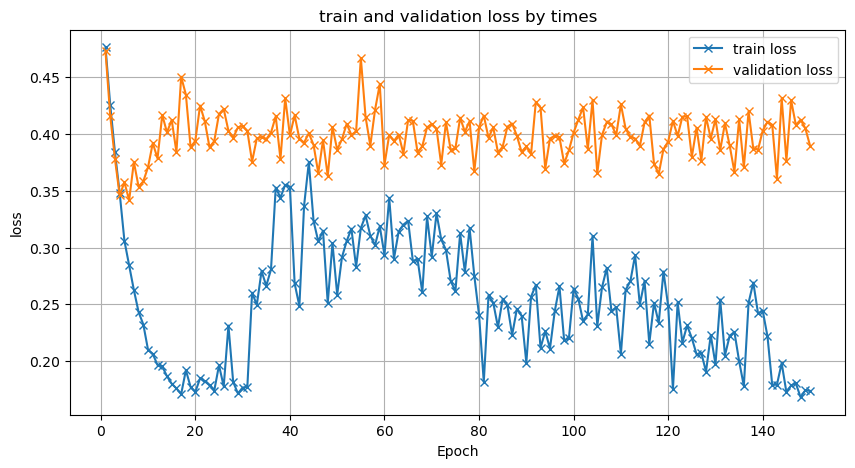

------Fold35-----
Epoch 1,train loss:0.4707, val loss:0.4873,train acc:0.4002, val acc:0.5060
Epoch 2,train loss:0.4212, val loss:0.4327,train acc:0.5087, val acc:0.5444
Epoch 3,train loss:0.3745, val loss:0.3999,train acc:0.5368, val acc:0.5755
Epoch 4,train loss:0.3491, val loss:0.3869,train acc:0.5632, val acc:0.5851
Epoch 5,train loss:0.3179, val loss:0.3827,train acc:0.5866, val acc:0.5612
Epoch 6,train loss:0.2881, val loss:0.3833,train acc:0.6171, val acc:0.6067
Epoch 7,train loss:0.2847, val loss:0.3980,train acc:0.6447, val acc:0.5803
Epoch 8,train loss:0.2673, val loss:0.3730,train acc:0.6279, val acc:0.5947
Epoch 9,train loss:0.2464, val loss:0.3869,train acc:0.6788, val acc:0.5947
Epoch 10,train loss:0.2374, val loss:0.3856,train acc:0.6663, val acc:0.5108
Epoch 11,train loss:0.2084, val loss:0.4043,train acc:0.7232, val acc:0.5659
Epoch 12,train loss:0.1967, val loss:0.4035,train acc:0.7052, val acc:0.5875
Epoch 13,train loss:0.1842, val loss:0.4353,train acc:0.7214, val a

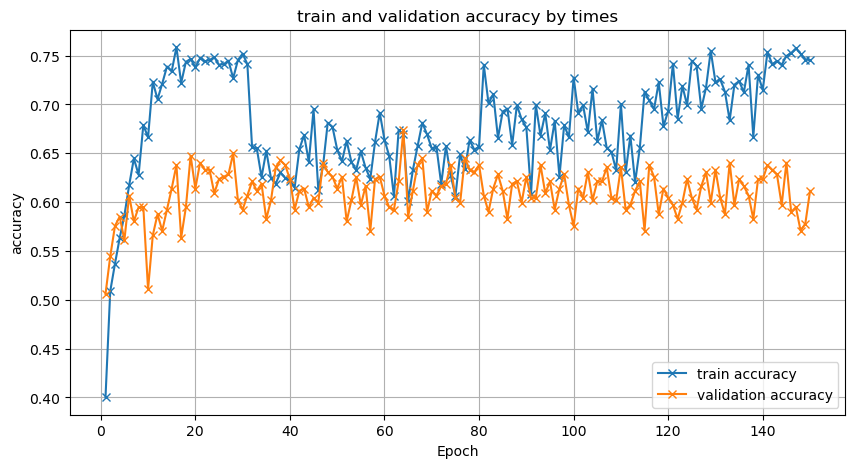

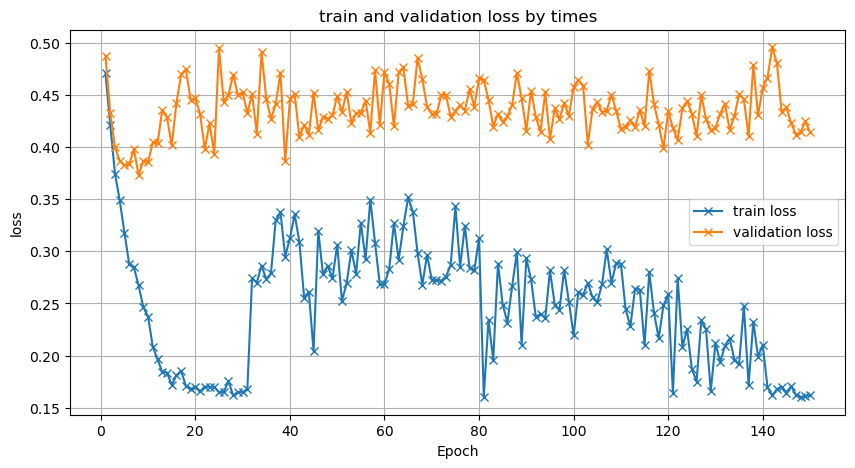

------Fold45-----
Epoch 1,train loss:0.4665, val loss:0.4661,train acc:0.4302, val acc:0.5396
Epoch 2,train loss:0.4098, val loss:0.4122,train acc:0.5315, val acc:0.5755
Epoch 3,train loss:0.3789, val loss:0.3738,train acc:0.5626, val acc:0.5588
Epoch 4,train loss:0.3356, val loss:0.3662,train acc:0.5578, val acc:0.5635
Epoch 5,train loss:0.3154, val loss:0.3833,train acc:0.6165, val acc:0.6091
Epoch 6,train loss:0.2896, val loss:0.3849,train acc:0.6261, val acc:0.5995
Epoch 7,train loss:0.2768, val loss:0.3784,train acc:0.6429, val acc:0.5923
Epoch 8,train loss:0.2617, val loss:0.3874,train acc:0.6609, val acc:0.6187
Epoch 9,train loss:0.2829, val loss:0.4088,train acc:0.6705, val acc:0.6043
Epoch 10,train loss:0.2416, val loss:0.3966,train acc:0.6537, val acc:0.5827
Epoch 11,train loss:0.2424, val loss:0.3672,train acc:0.6747, val acc:0.6043
Epoch 12,train loss:0.2286, val loss:0.3939,train acc:0.6794, val acc:0.5851
Epoch 13,train loss:0.2402, val loss:0.3962,train acc:0.6788, val a

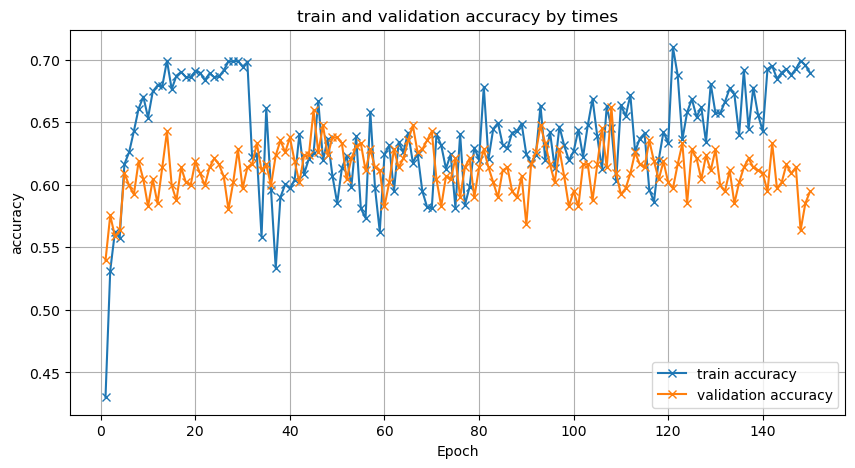

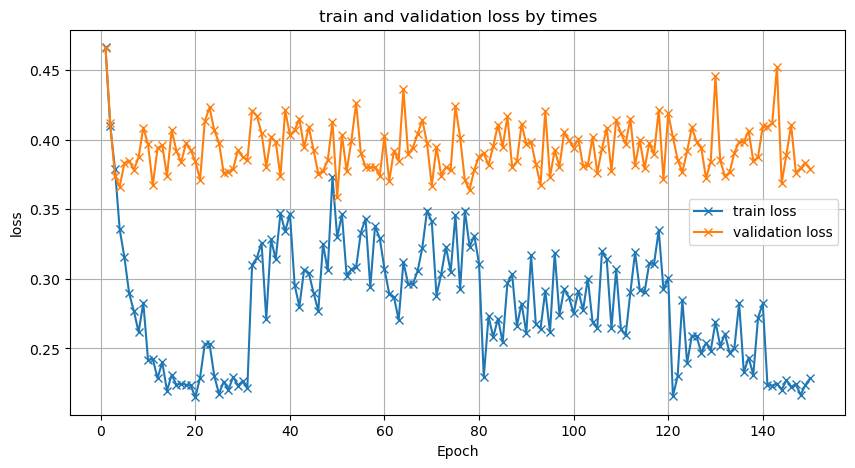

------Fold55-----
Epoch 1,train loss:0.4704, val loss:0.4829,train acc:0.4200, val acc:0.4844
Epoch 2,train loss:0.4208, val loss:0.4508,train acc:0.5285, val acc:0.5300
Epoch 3,train loss:0.3679, val loss:0.4307,train acc:0.5740, val acc:0.5396
Epoch 4,train loss:0.3368, val loss:0.4498,train acc:0.5848, val acc:0.5540
Epoch 5,train loss:0.3028, val loss:0.4277,train acc:0.6207, val acc:0.5755
Epoch 6,train loss:0.2986, val loss:0.4444,train acc:0.6231, val acc:0.5492
Epoch 7,train loss:0.2652, val loss:0.4272,train acc:0.6447, val acc:0.5851
Epoch 8,train loss:0.3022, val loss:0.4615,train acc:0.6459, val acc:0.5875
Epoch 9,train loss:0.2490, val loss:0.4520,train acc:0.6369, val acc:0.5803
Epoch 10,train loss:0.2407, val loss:0.4591,train acc:0.6747, val acc:0.6091
Epoch 11,train loss:0.2171, val loss:0.4404,train acc:0.6920, val acc:0.5635
Epoch 12,train loss:0.2111, val loss:0.4675,train acc:0.7052, val acc:0.5923
Epoch 13,train loss:0.2044, val loss:0.4743,train acc:0.6980, val a

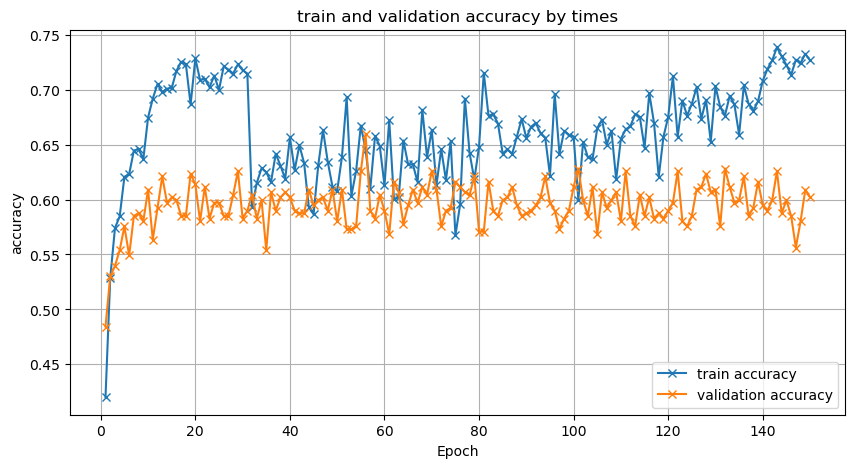

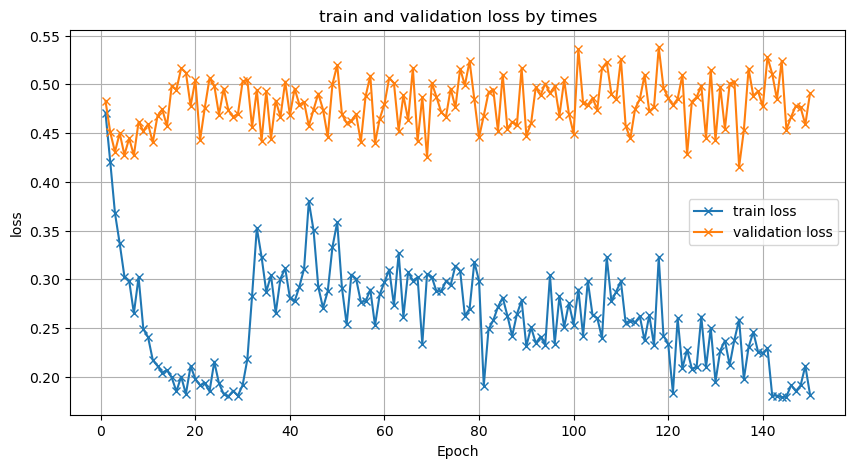


===== K-Fold Cross Validation 結果 =====
平均 Train Loss: 0.1845, 平均 Val Loss: 0.4146
平均 Train Acc: 0.7263, 平均 Val Acc: 0.6007


In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset,Subset
from torchvision import models
from torchvision import transforms
from PIL import Image
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from torchvision import datasets
from torch.optim.lr_scheduler import StepLR,ReduceLROnPlateau
import torch.nn.functional as F
import matplotlib.pyplot as plt
atl,avl,ata,ava=[],[],[],[]

#設定k-fold cross val
k=5
skf=StratifiedKFold(n_splits=k,shuffle=True,random_state=42)
datasetlist=list(td.dataset)

#開始訓練
for fold,(train_idx,val_idx) in enumerate(skf.split(np.zeros(len(datasetlist)),[label for _,label in datasetlist])):
    print(f"------Fold{fold+1}{k}-----")
    train_subset=Subset(td.dataset,train_idx)
    val_subset=Subset(td.dataset,val_idx)
    tdn=DataLoader(train_subset,batch_size=64,shuffle=True)
    vdn=DataLoader(val_subset,batch_size=64,shuffle=False)
    #設定模型
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model=models.efficientnet_b1(weights=models.EfficientNet_B1_Weights.DEFAULT)
    num_class=3
    model.classifier=nn.Sequential(nn.Dropout(0.35),nn.Linear(model.classifier[1].in_features,num_class))
    model.to(device)
    #設定損失函數，優化器，學習率調整器
    criterion=focalloss(class_num=3,alpha=cw,gamma=2)
    optimizer=torch.optim.AdamW(model.parameters(),lr=0.0001,weight_decay=0.01)
    scheduler=ReduceLROnPlateau(optimizer,factor=0.4,patience=2)
    #增強特徵學習
    mcup=mixupcutmix(alpha=0.5,mixup_prob=0.3,cutmix_prob=0.3)
    tlosses=[]
    vlosses=[]
    tacces=[]
    vacces=[]
    for epoch in range(0,150):
        if epoch <30:
            mcup.mixup_prob=0.0
            mcup.cutmix_prob=0.0
        elif 30<epoch and epoch<80:
            mcup.mixup_prob=0.3
            mcup.cutmix_prob=0.3    
        elif epoch >80 and epoch <120:
            mcup.mixup_prob=0.2
            mcup.cutmix_prob=0.2
        elif epoch >120 and epoch <140:
            mcup.mixup_prob=0.1
            mcup.cutmix_prob=0.1
        else:
            mcup.mixup_prob=0.0
            mcup.cutmix_prob=0.0
        model.train()
        train_loss=0.0
        ctrain,ttrain=0,0
        for images,labels in tdn:
            images,labels=images.to(device),labels.to(device)
            labels_onehot=F.one_hot(labels,num_classes=3).float()
            images,y_a,y_b,lam=mcup.mixup_cutmix(images,labels_onehot)
            outputs=model(images)
            loss=mcup.mixup_cutmix_criterion(criterion,outputs,y_a,y_b,lam)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss+= loss.item()
            _,predicted=torch.max(outputs,1)
            ctrain+=(predicted==labels).sum().item()
            ttrain+=labels.size(0)
        train_loss /=len(tdn)
        train_acc =ctrain/ttrain
        #計算驗證loss
        model.eval()
        val_loss=0.0
        cval,tval=0,0
        with torch.no_grad():
            for images,labels in vdn:
                images,labels=images.to(device),labels.to(device)
                labels_onehot=F.one_hot(labels,num_classes=3).float()
                outputs=model(images)
                loss= criterion(outputs,labels_onehot)
                val_loss +=loss.item()
                _,predicted=torch.max(outputs,1)
                cval+=(predicted==labels).sum().item()
                tval+=labels.size(0)
        val_loss /=  len(vdn)
        val_acc=cval/tval
        scheduler.step(val_loss)
        tlosses.append(train_loss)
        vlosses.append(val_loss)
        tacces.append(train_acc)
        vacces.append(val_acc)
        print(f"Epoch {epoch+1},train loss:{train_loss:.4f}, val loss:{val_loss:.4f},train acc:{train_acc:.4f}, val acc:{val_acc:.4f}")
    plt.figure(figsize=(10,5))
    plt.plot(range(1,len(tacces)+1), tacces,label='train accuracy',marker='x')
    plt.plot(range(1,len(vacces)+1), vacces,label='validation accuracy',marker='x')
    plt.xlabel('Epoch')
    plt.ylabel('accuracy')
    plt.title('train and validation accuracy by times')
    plt.legend()
    plt.grid()
    plt.show()
    plt.figure(figsize=(10,5))
    plt.plot(range(1,len(tlosses)+1), tlosses,label='train loss',marker='x')
    plt.plot(range(1,len(vlosses)+1), vlosses,label='validation loss',marker='x')
    plt.xlabel('Epoch')
    plt.ylabel('loss')
    plt.title('train and validation loss by times')
    plt.legend()
    plt.grid()
    plt.show()
    atl.append(tlosses)
    avl.append(vlosses)
    ata.append(tacces)
    ava.append(vacces)
mtl=np.mean(atl,axis=0)
mvl=np.mean(avl,axis=0)
mta=np.mean(ata,axis=0)
mva=np.mean(ava,axis=0)
print("\n===== K-Fold Cross Validation 結果 =====")
print(f"平均 Train Loss: {mtl[-1]:.4f}, 平均 Val Loss: {mvl[-1]:.4f}")

print(f"平均 Train Acc: {mta[-1]:.4f}, 平均 Val Acc: {mva[-1]:.4f}")

In [15]:
print("\n===== K-Fold Cross Validation 結果 =====")
print(f"平均 Train Loss: {mtl[-1]:.4f}, 平均 Val Loss: {mvl[-1]:.4f}")
print(f"平均 Train Acc: {mta[-1]:.4f}, 平均 Val Acc: {mva[-1]:.4f}")


===== K-Fold Cross Validation 結果 =====
平均 Train Loss: 0.2483, 平均 Val Loss: 0.4349
平均 Train Acc: 0.7017, 平均 Val Acc: 0.6045


In [65]:
torch.save(model.state_dict(),r"C:\Users\st030\drd\drdclassifier")#save model

In [67]:
import torchvision.models as models
model=models.efficientnet_b1(weights=None)
num_class=3
model.classifier=nn.Sequential(nn.Dropout(0.3),nn.Linear(model.classifier[1].in_features,num_class))
model.load_state_dict(torch.load(r"C:\Users\st030\drd\drdclassifier"))
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [69]:
import pandas as pd
from PIL import Image

class ImageDataset(Dataset):
    def __init__(self,root_dir,transform=None):
        self.root_dir=root_dir
        self.transform=transform
        self.image_paths=[os.path.join(root_dir,fname) for fname in os.listdir(root_dir) if fname.lower().endswith(('jpg','jpeg','png'))]
    def __len__(self):
        return len(self.image_paths)
    def __getitem__(self,idx):
        img_path=self.image_paths[idx]
        image=Image.open(img_path).convert('RGB')
        if self.transform:
            image=self.transform(image)
        return image,img_path
transform=transforms.Compose([transforms.RandomHorizontalFlip(),transforms.RandomRotation(20),transforms.RandomAffine(degrees=0,translate=(0.1,0.1)),transforms.ToTensor(),transforms.Normalize(mean=[0.75199205, 0.49642164, 0.3417683],std=[0.66117495, 0.45557284, 0.35461497])])
testdataset=ImageDataset(root_dir=r"C:\Users\st030\drd\retina-test",transform=transform)
testloader=DataLoader(testdataset,batch_size=64,shuffle=False)
predresult=[]
image_ids=[]
with torch.no_grad():
    for images,paths in testloader:
        images=images.to(device)
        outputs=model(images)
        pred=torch.argmax(outputs,dim=1)
        predresult.extend(pred.cpu().numpy())
        image_ids.extend(os.path.basename(p) for p in paths)
df= pd.DataFrame({"ID":image_ids,"Category":predresult})
df.to_csv("Result.csv",index=False)